### Connection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

/home/angelo-dev/miniconda3/envs/data_science/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Graph Analytics

- similarità tra utente e tra film
- provare ad aggiungere proprietà di grado o degree
- trovare community
- confrontare community
- recommendation system in base a quale community ti trovi

In [179]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-analyzed',
    {
        Movie:{properties:['minRating','maxRating','avgRating','stdRating','favoriteYear','favoriteMonth','year']},
        User:{properties: ['binaryGender','age','occupation','favoriteGenreId', 'ratings','minRating','maxRating','avgRating','stdRating','favoriteYear','favoriteMonth']},
        Genre:{properties: ['ratings']}
    },
    {
        RATED: {properties: 'rating', orientation: 'UNDIRECTED'},
        IN_GENRE:{},
        LIKES:{}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-analyzed,"{'User': {'label': 'User', 'properties': {'fav...",9943,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",2024939


In [180]:
gds.run_cypher(
    """
    CALL gds.graph.list('movies-analyzed')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.020484,"{'min': 0, 'max': 3430, 'p90': 508, 'p999': 25..."


## Similarity Analysis

In [181]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',{nodeLabels:['User','Genre'],relationshipTypes:['LIKES'], similarityCutoff: 0.2,writeRelationshipType: 'SIMILAR',
    writeProperty: 'score'}) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 60380

{'min': 0.5, 'p5': 1.0000038146972656, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.5, 'p10': 1.0000038146972656, 'p90': 1.0000038146972656, 'p50': 1.0000038146972656, 'p25': 1.0000038146972656, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.9806843545666669, 'p100': 1.0000038146972656, 'stdDev': 0.09623782762282082}


In [182]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',{nodeLabels:['Movie','Genre'],relationshipTypes:['IN_GENRE'], similarityCutoff: 0.5,writeRelationshipType: 'SIMILAR',
    writeProperty: 'score'}) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 38824

{'min': 0.5, 'p5': 0.6666641235351562, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.5, 'p10': 0.75, 'p90': 1.0000038146972656, 'p50': 1.0000038146972656, 'p25': 1.0000038146972656, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.9663858873535132, 'p100': 1.0000038146972656, 'stdDev': 0.10251835556287166}


### KNN

In [13]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed' ,{nodeLabels:['User'],writeRelationshipType: 'SIMILAR_KNN',
    writeProperty: 'score',nodeProperties: ['binaryGender','age','occupation', 'ratings','minRating','maxRating','avgRating','stdRating','favoriteGenreId','favoriteYear','favoriteMonth'],topK: 10, concurrency: 1, randomSeed: 42,similarityCutoff: 0.2})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 60400

{'min': 0.47796058654785156, 'p5': 0.7762660980224609, 'max': 1.0000057220458984, 'p99': 0.9220790863037109, 'p1': 0.7403507232666016, 'p10': 0.7895641326904297, 'p90': 0.9092159271240234, 'p50': 0.8484859466552734, 'p25': 0.8193340301513672, 'p75': 0.8651523590087891, 'p95': 0.9101123809814453, 'mean': 0.8434759764955533, 'p100': 1.0000057220458984, 'stdDev': 0.04076791105467754}


In [184]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed' ,{nodeLabels:['Movie'],writeRelationshipType: 'SIMILAR_KNN',
    writeProperty: 'score',nodeProperties: ['minRating','maxRating','avgRating','stdRating','favoriteYear','favoriteMonth','year'],topK: 3, concurrency: 1, randomSeed: 42,similarityCutoff: 0.5})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 11655

{'min': 0.6111106872558594, 'p5': 0.860626220703125, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.7884063720703125, 'p10': 0.8928565979003906, 'p90': 1.0000038146972656, 'p50': 1.0000038146972656, 'p25': 0.9285697937011719, 'p75': 1.0000038146972656, 'p95': 1.0000038146972656, 'mean': 0.966939859868937, 'p100': 1.0000038146972656, 'stdDev': 0.05293862140752733}


## Recommendation Systems

In [185]:
import random

random.seed(0)

### Movie based

In [186]:
movieId = random.randint(0, 3952)

gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId = {movieId}
    RETURN m.title as title
    """
).loc[0]["title"]

'Blood and Sand (Sangre y Arena) (1989)'

In [187]:
gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR]-(m2:Movie)
    RETURN m2.title as title, s.score as score
    ORDER BY score DESC
    limit 10
    """
)

,title,score
0,Bridges of Madison County The (1995),1.0
1,Frankie Starlight (1995),1.0
2,Postino Il (The Postman) (1994),1.0
3,Angels and Insects (1995),1.0
4,How to Make an American Quilt (1995),1.0
5,Leaving Las Vegas (1995),1.0
6,When Night Is Falling (1995),1.0
7,Carrington (1995),1.0
8,Bed of Roses (1996),1.0
9,Sense and Sensibility (1995),1.0


In [188]:
gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_KNN]-(m2:Movie)
    RETURN m2.title as title, s.score as score
    ORDER BY score DESC
    limit 10
    """
)

,title,score
0,Death in Brunswick (1991),0.904762
1,Death in Brunswick (1991),0.904762
2,Johnny 100 Pesos (1993),0.885714
3,Metisse (Caf� au Lait) (1993),0.885714
4,Fausto (1993),0.885714
5,Metisse (Caf� au Lait) (1993),0.885714
6,Johnny 100 Pesos (1993),0.885714
7,Make Them Die Slowly (Cannibal Ferox) (1980),0.871429
8,Make Them Die Slowly (Cannibal Ferox) (1980),0.871429
9,Napoleon and Samantha (1972),0.865079


### User based

In [189]:
userId = random.randint(1, 6040)

gds.run_cypher(
    f"""
    MATCH (u:User {{userId: {userId}}})
    RETURN u.userId, u.age, u.occupation, u.binaryGender, u.favoriteGenreId, u.favoriteYear, u.favoriteMonth, u.ratings, u.minRating, u.maxRating, u.avgRating, u.stdRating
    """
)

,u.userId,u.age,u.occupation,u.binaryGender,u.favoriteGenreId,u.favoriteYear,u.favoriteMonth,u.ratings,u.minRating,u.maxRating,u.avgRating,u.stdRating
0,2485,35,14,0,1,2000,11,246,1,5,3,0


In [190]:
gds.run_cypher(
    f"""
    MATCH (u:User {{userId: {userId}}})-[s:SIMILAR]-(u2:User)
    WITH u2.userId as similarUserId, s.score as score
    ORDER BY score DESC
    limit 5
    CALL
    {{ 
        WITH similarUserId
        MATCH (u:User {{userId: similarUserId}})-[r:RATED]->(m:Movie)
        RETURN m.title as title, r.rating as rating
        ORDER BY rating DESC
        LIMIT 2
    }}
    RETURN similarUserId,title,score
    """
)

,similarUserId,title,score
0,81,Graduate The (1967),1.0
1,81,Sting The (1973),1.0
2,63,Crying Game The (1992),1.0
3,63,Amadeus (1984),1.0
4,57,Raging Bull (1980),1.0
5,57,Christmas Story A (1983),1.0
6,58,Robocop (1987),1.0
7,58,Glory (1989),1.0
8,58,Robocop (1987),1.0
9,58,Glory (1989),1.0


In [191]:
gds.run_cypher(
    f"""
    MATCH (u:User {{userId: {userId}}})-[s:SIMILAR_KNN]-(u2:User)
    WITH u2.userId as similarUserId, s.score as score
    ORDER BY score DESC
    limit 5
    CALL
    {{ 
        WITH similarUserId
        MATCH (u:User {{userId: similarUserId}})-[r:RATED]->(m:Movie)
        RETURN m.title as title, r.rating as rating
        ORDER BY rating DESC
        LIMIT 2
    }}
    RETURN similarUserId,title,score
    """
)

,similarUserId,title,score
0,2251,Glengarry Glen Ross (1992),0.909632
1,2251,Reservoir Dogs (1992),0.909632
2,2251,Glengarry Glen Ross (1992),0.909632
3,2251,Reservoir Dogs (1992),0.909632
4,2251,Glengarry Glen Ross (1992),0.909632
5,2251,Reservoir Dogs (1992),0.909632
6,2251,Glengarry Glen Ross (1992),0.909632
7,2251,Reservoir Dogs (1992),0.909632
8,793,Dune (1984),0.864574
9,793,To Kill a Mockingbird (1962),0.864574


## Community detection


[docs](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/#algorithms-louvain-intro)  
[esample of recommendations system](https://neo4j.com/docs/graph-data-science-client/current/tutorials/fastrp-and-knn/)

- Provare con similarità diverse
- Provare con tutto il grafo

In [192]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-communities',
    ['User','Movie','Genre'],
    {
        SIMILAR: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR_KNN: {properties: 'score', orientation: 'UNDIRECTED'},
        RATED: {orientation: 'UNDIRECTED'},
        IN_GENRE: {orientation: 'UNDIRECTED'},
        LIKES: {orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'users-communities' already exists.}

In [15]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-similarities',
    'User'
    ,
    {
        SIMILAR: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR_KNN: {properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,users-similarities,"{'User': {'label': 'User', 'properties': {}}}",6040,"{'SIMILAR': {'aggregation': 'DEFAULT', 'orient...",430066


In [16]:
gds.run_cypher(
    """
    CALL gds.graph.list('users-similarities')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.011791,"{'min': 16, 'max': 2283, 'p90': 73, 'p999': 22..."


In [17]:
gds.run_cypher(
    """
    CALL gds.louvain.stats('users-similarities', { relationshipWeightProperty:'score',maxIterations:1000,includeIntermediateCommunities:true})
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,26,0.552647,"[0.5448327388764687, 0.5526469538031438]"


In [18]:
gds.run_cypher(
    """
    CALL gds.louvain.write('users-similarities', { relationshipWeightProperty: 'score',writeProperty:'communityId',maxIterations:1000})
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,26,0.553039,"[0.5457946785809826, 0.5530385800639239]"


In [19]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.communityId as communityId, COUNT(*) as numNodes
    ORDER BY numNodes DESC
    LIMIT 5
    """
)
communityId1 = result.iloc[0]["communityId"]
communityId2 = result.iloc[1]["communityId"]
result

,communityId,numNodes
0,4608,1103
1,3695,1075
2,5748,773
3,24,620
4,1312,457


### We will pick the two biggest community

In [20]:
from helpers import AGE_LABELS, OCCUPATION_LABELS


community1 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})
    RETURN u.age AS age, u.occupation AS occupation, u.gender AS gender,u.favoriteGenre AS favoriteGenre, u.favoriteYear AS favoriteYear, u.favoriteMonth AS favoriteMonth, u.ratings AS ratings, u.minRating AS minRating, u.maxRating AS maxRating, u.avgRating AS avgRating, u.stdRating AS stdRating
    """
)
community1_age = community1["age"].value_counts().rename(index=AGE_LABELS).sort_index()
community1_occupation = (
    community1["occupation"]
    .value_counts()
    .rename(index=OCCUPATION_LABELS)
    .sort_values()
)


community2 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})
    RETURN u.age AS age, u.occupation AS occupation, u.gender AS gender,u.favoriteGenre AS favoriteGenre, u.favoriteYear AS favoriteYear, u.favoriteMonth AS favoriteMonth, u.ratings AS ratings, u.minRating AS minRating, u.maxRating AS maxRating, u.avgRating AS avgRating, u.stdRating AS stdRating
    """
)
community2_age = community2["age"].value_counts().rename(index=AGE_LABELS).sort_index()
community2_occupation = (
    community2["occupation"]
    .value_counts()
    .rename(index=OCCUPATION_LABELS)
    .sort_values()
)

<Axes: title={'center': 'Occupation distribution'}, xlabel='occupation'>

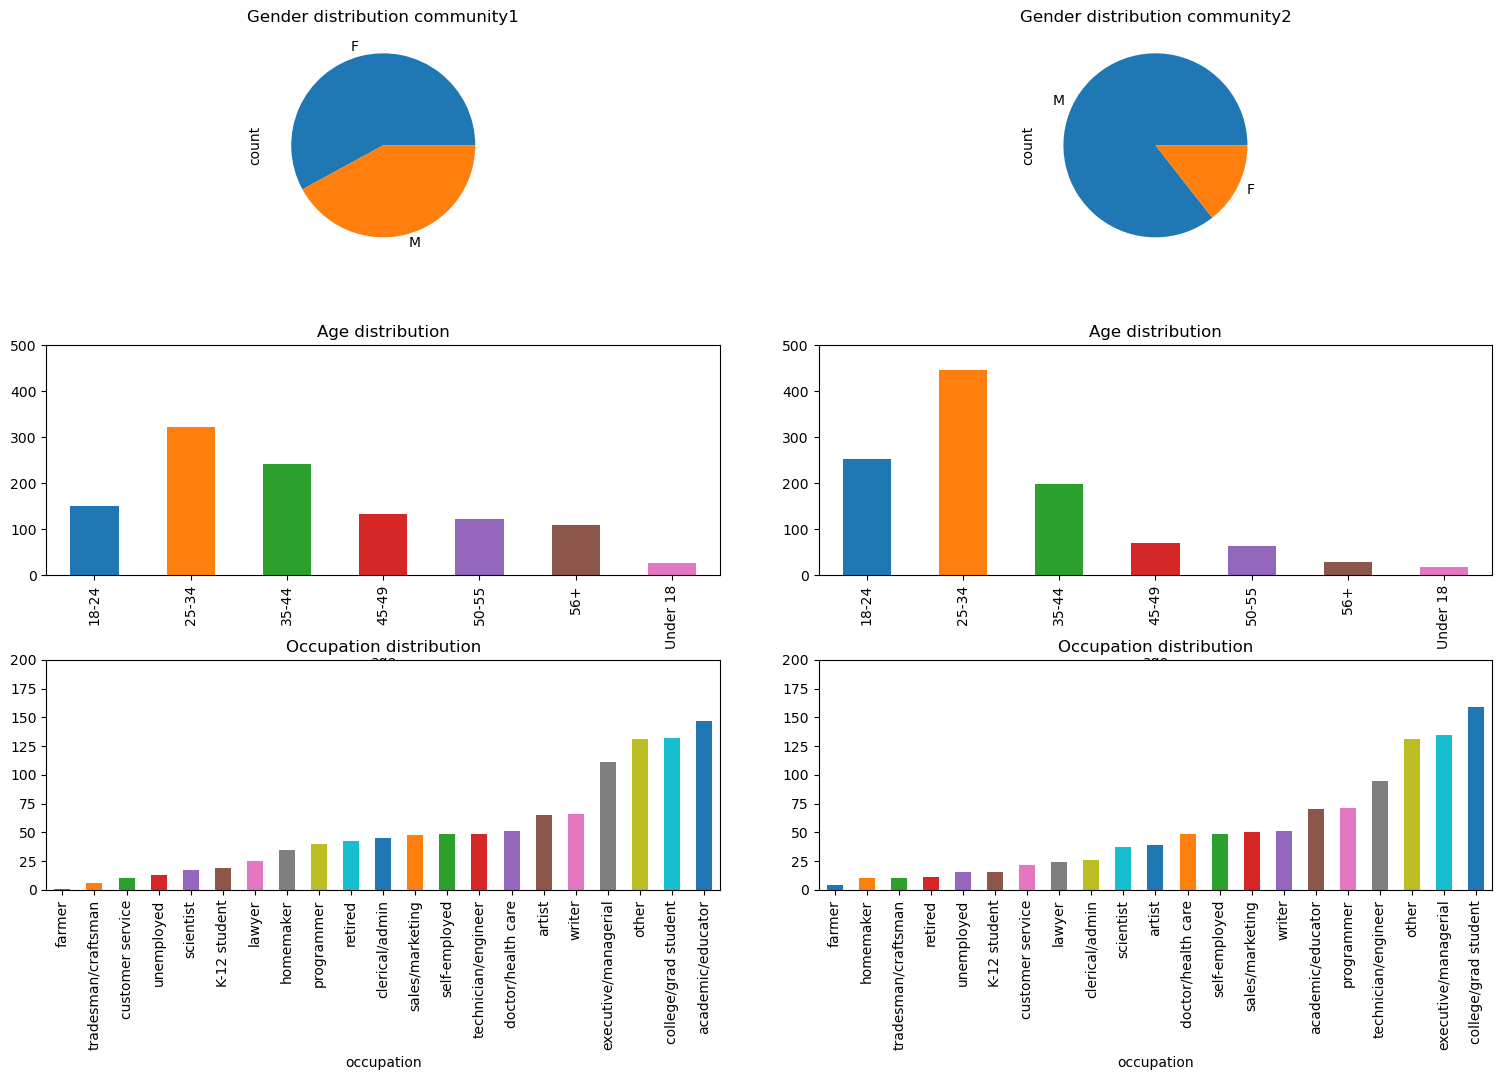

In [22]:
from matplotlib.colors import TABLEAU_COLORS

fig, ax = plt.subplots(3, 2, figsize=(16, 10))
fig.tight_layout(pad=4)
community1["gender"].value_counts().plot(
    kind="pie", title="Gender distribution community1", ax=ax[0, 0]
)
community2["gender"].value_counts().plot(
    kind="pie", title="Gender distribution community2", ax=ax[0, 1]
)
community1_age.plot(
    kind="bar",
    title="Age distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 500),
    ax=ax[1, 0],
)
community2_age.plot(
    kind="bar",
    title="Age distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 500),
    ax=ax[1, 1],
)
community1_occupation.plot(
    kind="bar",
    title="Occupation distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 200),
    ax=ax[2, 0],
)
community2_occupation.plot(
    kind="bar",
    title="Occupation distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 200),
    ax=ax[2, 1],
)

<Axes: title={'center': 'Favorite Month'}, xlabel='favoriteMonth'>

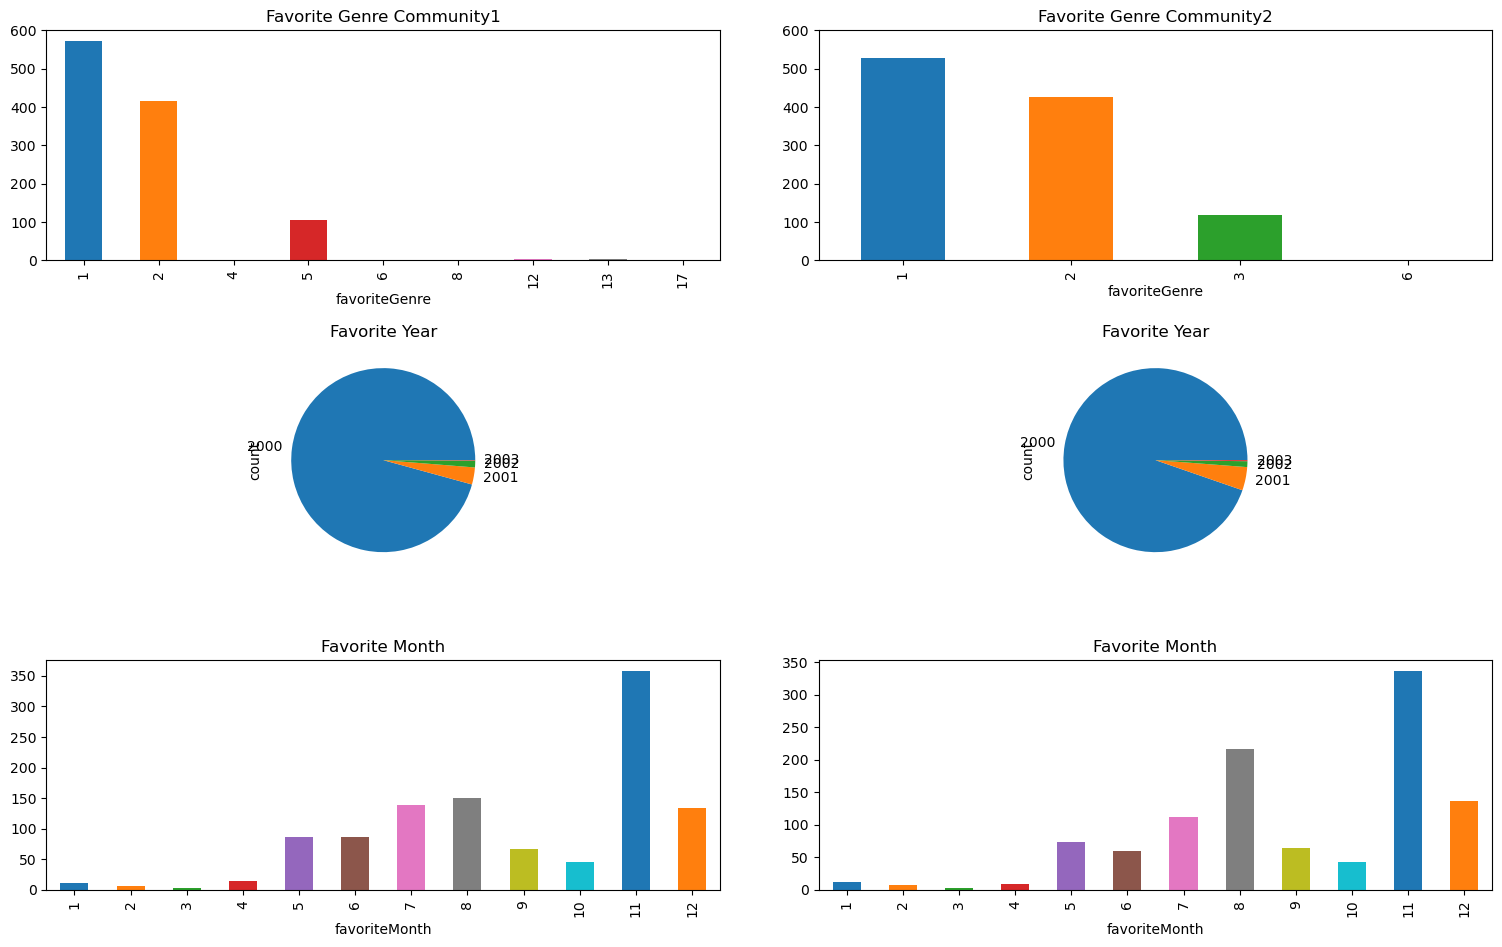

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(16, 10))
fig.tight_layout(pad=4)
community1["favoriteGenre"].value_counts().sort_index().plot(
    kind="bar",
    title="Favorite Genre Community1",
    color=TABLEAU_COLORS,
    ylim=(0, 600),
    ax=ax[0, 0],
)
community2["favoriteGenre"].value_counts().sort_index().plot(
    kind="bar",
    title="Favorite Genre Community2",
    color=TABLEAU_COLORS,
    ylim=(0, 600),
    ax=ax[0, 1],
)
community1["favoriteYear"].value_counts().sort_index().plot(
    kind="pie", title="Favorite Year", ax=ax[1, 0]
)
community2["favoriteYear"].value_counts().sort_index().plot(
    kind="pie", title="Favorite Year", ax=ax[1, 1]
)
community1["favoriteMonth"].value_counts().sort_index().plot(
    kind="bar", title="Favorite Month", color=TABLEAU_COLORS, ax=ax[2, 0]
)
community2["favoriteMonth"].value_counts().sort_index().plot(
    kind="bar", title="Favorite Month", color=TABLEAU_COLORS, ax=ax[2, 1]
)

<Axes: title={'center': 'Std Rating distribution'}, ylabel='count'>

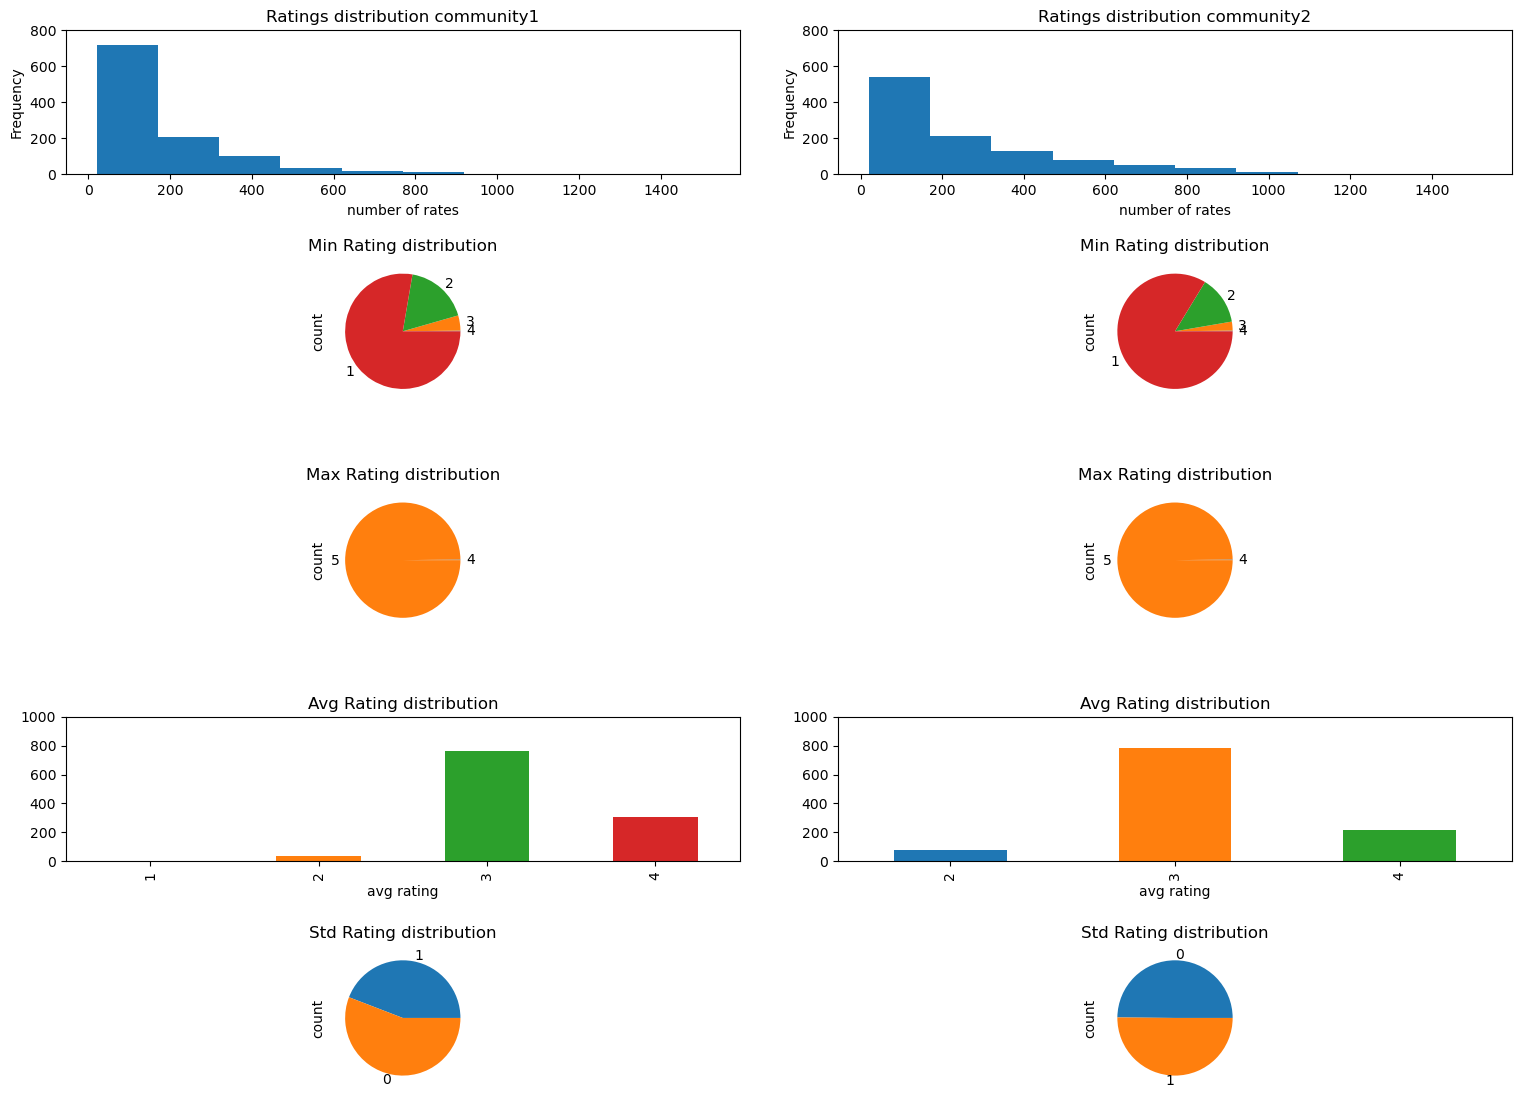

In [24]:
fig, ax = plt.subplots(5, 2, figsize=(16, 12))
fig.tight_layout(pad=4)
community1["ratings"].sort_values().plot(
    kind="hist",
    title="Ratings distribution community1",
    xlabel="number of rates",
    ylim=(0, 800),
    ax=ax[0, 0],
)
community2["ratings"].sort_values().plot(
    kind="hist",
    title="Ratings distribution community2",
    xlabel="number of rates",
    ylim=(0, 800),
    ax=ax[0, 1],
)
community1["minRating"].value_counts().sort_values().plot(
    kind="pie", title="Min Rating distribution", color=TABLEAU_COLORS, ax=ax[1, 0]
)
community2["minRating"].value_counts().sort_values().plot(
    kind="pie", title="Min Rating distribution", color=TABLEAU_COLORS, ax=ax[1, 1]
)
community1["maxRating"].value_counts().sort_values().plot(
    kind="pie", title="Max Rating distribution", color=TABLEAU_COLORS, ax=ax[2, 0]
)
community2["maxRating"].value_counts().sort_values().plot(
    kind="pie", title="Max Rating distribution", color=TABLEAU_COLORS, ax=ax[2, 1]
)
community1["avgRating"].value_counts().sort_index().plot(
    kind="bar",
    title="Avg Rating distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 1000),
    xlabel="avg rating",
    ax=ax[3, 0],
)
community2["avgRating"].value_counts().sort_index().plot(
    kind="bar",
    title="Avg Rating distribution",
    color=TABLEAU_COLORS,
    ylim=(0, 1000),
    xlabel="avg rating",
    ax=ax[3, 1],
)
community1["stdRating"].value_counts().sort_values().plot(
    kind="pie",
    title="Std Rating distribution",
    color=TABLEAU_COLORS,
    xlabel="std rating",
    ax=ax[4, 0],
)
community2["stdRating"].value_counts().sort_values().plot(
    kind="pie",
    title="Std Rating distribution",
    color=TABLEAU_COLORS,
    xlabel="std rating",
    ax=ax[4, 1],
)

In [25]:
gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})-[r:RATED WHERE r.rating>3]->(m:Movie)
    WITH m, COUNT(r) AS numPositiveRatings
    RETURN m.title AS title, numPositiveRatings
    ORDER BY numPositiveRatings DESC, title  DESC
    LIMIT 10
"""
)

,title,numPositiveRatings
0,Shakespeare in Love (1998),607
1,American Beauty (1999),595
2,Groundhog Day (1993),475
3,When Harry Met Sally... (1989),414
4,Being John Malkovich (1999),412
5,Schindler's List (1993),408
6,Shawshank Redemption The (1994),402
7,Fargo (1996),397
8,Princess Bride The (1987),395
9,Forrest Gump (1994),389


In [26]:
gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})-[r:RATED WHERE r.rating>3]->(m:Movie)
    WITH m, COUNT(r) AS numPositiveRatings
    RETURN m.title AS title, numPositiveRatings
    ORDER BY numPositiveRatings DESC, title  DESC
    LIMIT 10
"""
)

,title,numPositiveRatings
0,Raiders of the Lost Ark (1981),654
1,Star Wars: Episode IV - A New Hope (1977),652
2,American Beauty (1999),648
3,Star Wars: Episode V - The Empire Strikes Back...,641
4,Saving Private Ryan (1998),578
5,Princess Bride The (1987),560
6,Braveheart (1995),555
7,Back to the Future (1985),544
8,Godfather The (1972),542
9,Star Wars: Episode VI - Return of the Jedi (1983),541


In [27]:
community1_movies = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})-[r:RATED]->(m:Movie)
    WITH m, AVG(r.rating) AS avgRating
    RETURN m.movieId AS movieId, avgRating
    """
)

community2_movies = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})-[r:RATED]->(m:Movie)
    WITH m, AVG(r.rating) AS avgRating
    RETURN m.movieId AS movieId, avgRating
    """
)

In [28]:
movies = community1_movies.merge(
    community2_movies,
    on="movieId",
    how="outer",
    suffixes=("_community1", "_community2"),
)

In [29]:
movies = (
    movies[
        (movies["avgRating_community1"].isnull())
        | (movies["avgRating_community2"].isnull())
    ]
    .sort_values(by=["avgRating_community1", "avgRating_community2"], ascending=False)
    .reset_index(drop=True)
)

In [30]:
movies

,movieId,avgRating_community1,avgRating_community2
0,404,5.0,NaN
1,572,5.0,NaN
2,854,5.0,NaN
3,1360,5.0,NaN
4,1901,5.0,NaN
...,...,...,...
292,3772,NaN,1.0
293,3800,NaN,1.0
294,3828,NaN,1.0
295,3875,NaN,1.0


<Axes: title={'center': 'Average rating per movie'}>

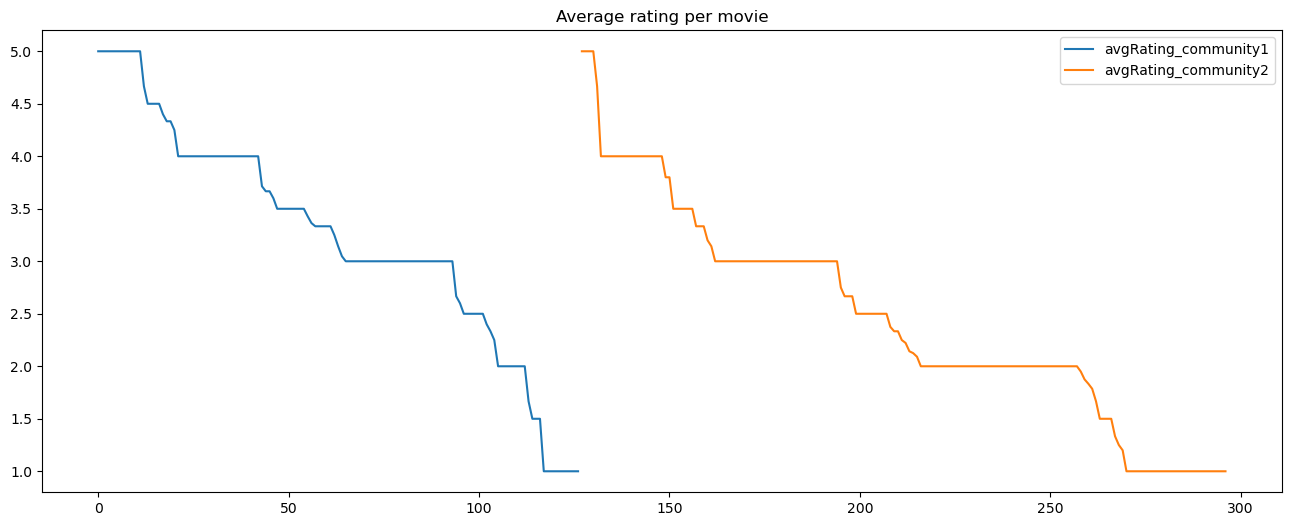

In [31]:
movies.plot(
    kind="line",
    y=["avgRating_community1", "avgRating_community2"],
    title="Average rating per movie",
    figsize=(16, 6),
)

In [32]:
community1_genre = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId1})-[r:RATED]->(m:Movie)-[:IN_GENRE]->(g:Genre)
    WITH g, AVG(r.rating) AS avgRating
    RETURN g.name AS genre, avgRating
    """
)

community2_genre = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communityId2})-[r:RATED]->(m:Movie)-[:IN_GENRE]->(g:Genre)
    WITH g, AVG(r.rating) AS avgRating
    RETURN g.name AS genre, avgRating
    """
)

In [33]:
community1_genre.sort_values(by="avgRating", ascending=False)

,genre,avgRating
12,Film-Noir,4.063696
17,Documentary,4.043292
3,War,3.899041
2,Drama,3.789263
15,Musical,3.785568
11,Animation,3.750067
8,Mystery,3.736011
9,Crime,3.701879
4,Romance,3.691611
1,Comedy,3.599636


In [34]:
community2_genre.sort_values(by="avgRating", ascending=False)

,genre,avgRating
16,Film-Noir,4.044867
13,Documentary,3.914313
9,War,3.876829
3,Drama,3.752051
2,Crime,3.688150
17,Animation,3.685020
14,Western,3.662183
15,Musical,3.597749
12,Mystery,3.586142
5,Romance,3.555069


TODO  
- stampa tutte le informazioni degli utenti della prima e seconda community
- poi fai i plot delle loro distribuzioni
- analizza i grafici